# Preprocessing - Converting to images

Raw malwares will be stored in the following folder:

In [143]:
root = "D:/YOLOV5 AND LABELIMG TOOLS/malimg_paper_dataset_imgs"

In [144]:
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt

## This function allows us to process our hexadecimal files into png images##
def convertAndSave(array,name):
    print('Processing '+name)
    if array.shape[1]!=16: #If not hexadecimal
        assert(False)
    b=int((array.shape[0]*16)**(0.5))
    b=2**(int(log(b)/log(2))+1)
    a=int(array.shape[0]*16/b)
    array=array[:a*b//16,:]
    array=np.reshape(array,(a,b))
    im = Image.fromarray(np.uint8(array))
    im.save(root+'\\'+name+'.png', "PNG")
    return im

#Get the list of files
files=os.listdir(root)
print('files : ',files)
#We will process files one by one.
for counter, name in enumerate(files):
        #We only process .bytes files from our folder.
        if '.bytes' != name[-6:]:
            continue
        f=open(root+'/'+name)
        array=[]
        for line in f:
            xx=line.split()
            if len(xx)!=17:
                continue
            array.append([int(i,16) if i!='??' else 0 for i in xx[1:] ])
        plt.imshow(convertAndSave(np.array(array),name))
        del array
        f.close()

files :  ['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.gen!g', 'C2LOP.P', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A']


# Preprocessing - Generate the dataset

Here is our new folder :

In [145]:
path_root = "D:/YOLOV5 AND LABELIMG TOOLS/malimg_paper_dataset_imgs"

In [146]:
from keras.preprocessing.image import ImageDataGenerator
batches = ImageDataGenerator().flow_from_directory(directory=path_root, target_size=(64,64), batch_size=10000)

Found 9339 images belonging to 25 classes.


In [147]:
batches.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [148]:
imgs, labels = next(batches)

In [149]:
imgs.shape

(9339, 64, 64, 3)

In [150]:
labels.shape

(9339, 25)

The following method allows us to plot a sample of images in our dataset.

In [151]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

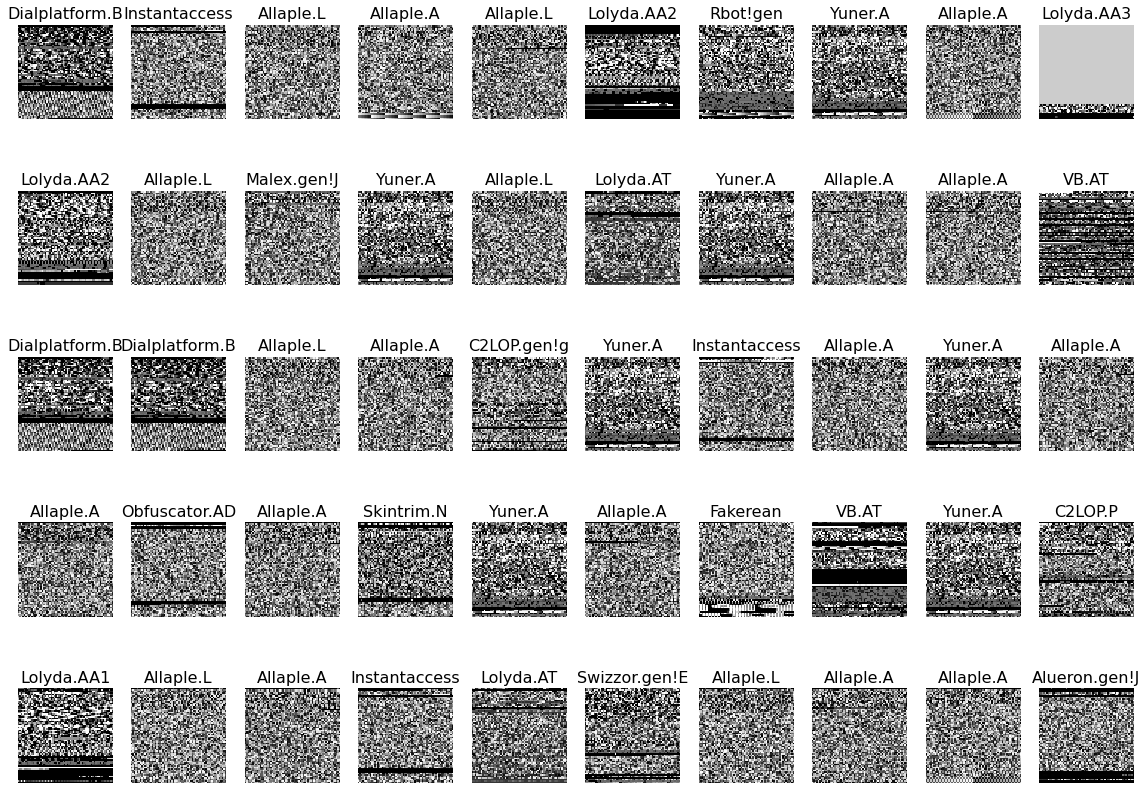

In [152]:
plots(imgs, titles = labels)

# Analyse 

In [153]:
classes = batches.class_indices.keys()

In [154]:
perc = (sum(labels)/labels.shape[0])*100

<BarContainer object of 25 artists>

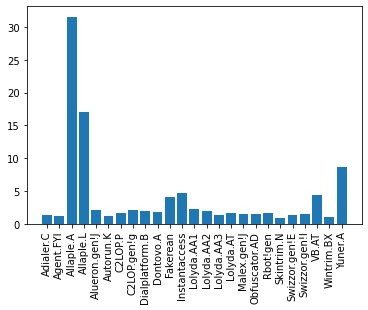

In [155]:
plt.xticks(rotation='vertical')
plt.bar(classes,perc)

# Train and test

Lets split our model into train and test following a ratio 70% train - 30% test ratio.

In [156]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

In [157]:

X_train.shape

(6537, 64, 64, 3)

In [158]:
X_test.shape

(2802, 64, 64, 3)

In [159]:
y_train.shape

(6537, 25)

In [160]:
y_test.shape

(2802, 25)

## Alexnet Model

In [161]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
#resnet50 = keras.applications.resnet50
from keras.applications.resnet import ResNet50


We want **25** classes as output.

In [162]:
num_classes = 25

Building the model

In [163]:
def AlexnetModel(input_shape,num_classes):
  model = Sequential()
  model.add(Conv2D(filters=96,kernel_size=(3,3),strides=(4,4),input_shape=input_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(256,(5,5),padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
  model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
  model.add(Conv2D(256,(3,3),padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(num_classes,activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
  return model

In [164]:
input_shape = (64,64,3)

In [165]:
Malware_model=AlexnetModel(input_shape,num_classes)

In [166]:
y_train.shape

(6537, 25)

In [167]:
y_train_new = np.argmax(y_train, axis=1)

In [168]:
y_train_new

array([ 3, 22, 24, ..., 19,  3, 11], dtype=int64)

In [169]:
'''from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_new),
                                                 y_train_new)'''

C:\Users\Rana Saeed\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24], y=[ 3 22 24 ... 19  3 11] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [170]:
Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)#  class_weight=class_weights)

Epoch 1/10
205/205 [==============================] - 245s 1s/step - loss: 1.7017 - accuracy: 0.4609 - val_loss: 0.8385 - val_accuracy: 0.6567
Epoch 2/10
205/205 [==============================] - 225s 1s/step - loss: 0.5655 - accuracy: 0.8128 - val_loss: 0.6480 - val_accuracy: 0.8059
Epoch 3/10
205/205 [==============================] - 242s 1s/step - loss: 0.2660 - accuracy: 0.9186 - val_loss: 0.6303 - val_accuracy: 0.8526
Epoch 4/10
205/205 [==============================] - 249s 1s/step - loss: 0.2451 - accuracy: 0.9234 - val_loss: 0.2910 - val_accuracy: 0.9193
Epoch 5/10
205/205 [==============================] - 245s 1s/step - loss: 0.1910 - accuracy: 0.9399 - val_loss: 0.2256 - val_accuracy: 0.9411
Epoch 6/10
205/205 [==============================] - 234s 1s/step - loss: 0.1757 - accuracy: 0.9434 - val_loss: 0.2179 - val_accuracy: 0.9404
Epoch 7/10
205/205 [==============================] - 224s 1s/step - loss: 0.1316 - accuracy: 0.9599 - val_loss: 0.2762 - val_accuracy: 0.9343

In [171]:
scores = Malware_model.evaluate(X_test, y_test)

88/88 [==============================] - 19s 218ms/step - loss: 0.2585 - accuracy: 0.9418


In [172]:
print('Final CNN accuracy: ', scores[1])

Final CNN accuracy:  0.9418272376060486


# Confusion Matrix

Lets analyse our results.

In [173]:
import numpy as np
import pandas as pd
y_test.shape

(2802, 25)

In [174]:
y_pred = Malware_model.predict(X_test, verbose=0)
y_pred.shape

(2802, 25)

In [175]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))


In [176]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

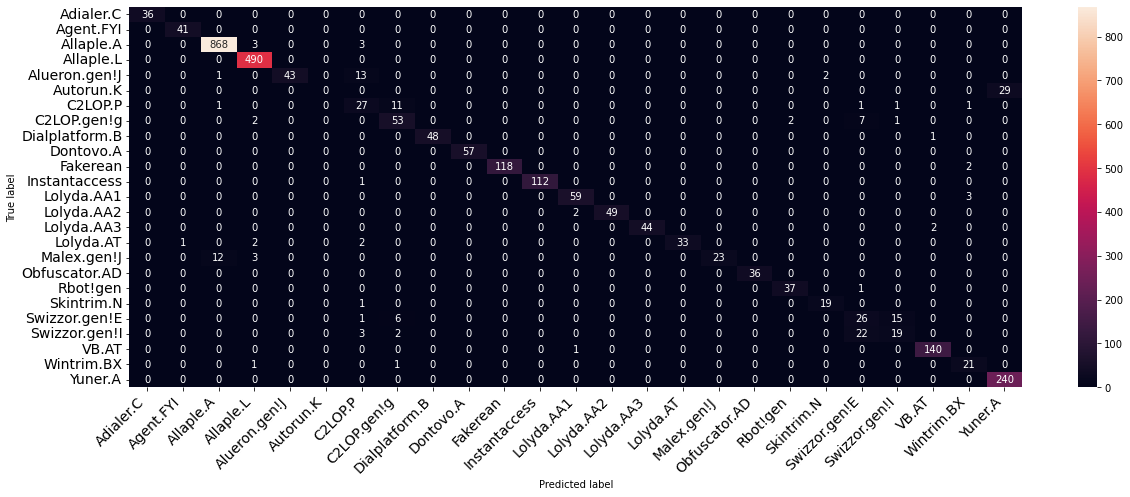

In [177]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)